This notebook shows an example of using the Fixed-Point implementation of an ensemble of neurons.

In [1]:
%matplotlib inline
import pylab
import numpy as np
import nengo           # this can be installed with "pip install nengo --user"
import fixed_ensemble  # this is just a file in this directory

In this example, we create 100 neurons computing this function from $\mathbb{R} \rightarrow \mathbb{R}^2$: $y=[x^2, -x]$.  You can change the code below to change the function being computed.

In [2]:
n_neurons = 100  # number of neurons in the ensemble

n_inputs = 1     # the dimensionality of the input.  If you change this, you must
                 #  change train_signal (below) to have that dimensionality
    
n_outputs = 2    # the dimensionality of the output.  If you change this, you must
                 #  make sure the desired_function outputs that same dimensionality
    
desired_function = lambda x: (x[0]**2, -x[0])  # the function to approximate with the neurons

seed = 1         # random number seed used to generate neuron properties

ens = fixed_ensemble.FixedEnsemble(n_inputs=n_inputs, 
                                   n_outputs=n_outputs,
                                   n_neurons=n_neurons,
                                   seed=seed)



First, we need to determine the decoders that will give us the function we desire.  This is usually done offline, by feeding input into a simulation of the neurons, gathering the spiking output over time, and then computing the decoder.  In this case, we use the actual neuron code itself, and gather the ```.spikes``` data.  However, the real design on an FPGA would not be expected to store or provide the ```.spikes``` data.  Instead, we would either compute the decoders based on this simulation of the chip, or use an online learning rule to adjust the decoders.

In [3]:
# number of time steps to train for
train_time = 2000

train_t = np.arange(train_time)

# the signal provided for training
train_signal = np.sin(train_t * 2 * np.pi / 1000)
train_signal.shape = train_time, n_inputs

# run the neurons with that input and record the spikes
spikes = np.zeros((train_time, n_neurons))
for i in range(train_time):
    ens.step(train_signal[i]*ens.input_max)
    spikes[i] = ens.spikes

Now we compute the decoders

In [4]:
filter = nengo.synapses.Lowpass(10)
solver = nengo.solvers.LstsqL2()

target = np.array([desired_function(x) for x in train_signal])
decoder, info = solver(filter.filt(spikes, dt=1), filter.filt(target, dt=1))

Just to check, we can now plot what that ideal computed decoder would perform like.  The resulting error is extremely small.

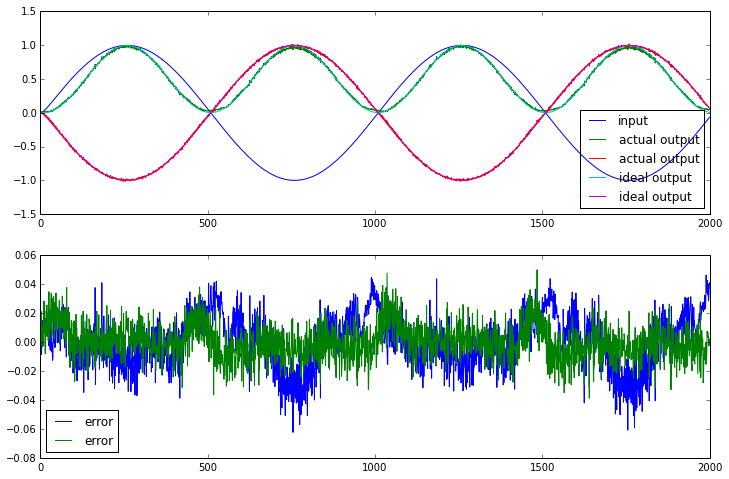

In [5]:
decoded = np.dot(spikes, decoder)

error = filter.filt(decoded, dt=1) - filter.filt(target, dt=1)

pylab.figure(figsize=(12,8))
pylab.subplot(2, 1, 1)
pylab.plot(train_t, filter.filt(train_signal, dt=1), label='input')
pylab.plot(train_t, filter.filt(decoded, dt=1), label='actual output')
pylab.plot(train_t, filter.filt(target, dt=1), label='ideal output', lw=1)
pylab.legend(loc='best')
pylab.subplot(2, 1, 2)
pylab.plot(train_t, error, label='error')
pylab.legend(loc='best')
pylab.show()

Now we set the decoder values for the neurons and run it again.  To make sure it is generalizing it well, instead of testing it on a sine wave input, we generate a gaussian white noise signal and use that instead. 

In [6]:
ens.set_decoders(decoder)

test_time = 4000
output = np.zeros((test_time, n_outputs))

test_t = np.arange(test_time)

rng = np.random.RandomState(seed=1)
test_signal = nengo.processes.WhiteSignal(period=2, high=5).run(test_time*0.001, dt=0.001, rng=rng, d=n_inputs)

test_signal.shape = test_time, n_inputs
test_target = np.array([desired_function(x) for x in test_signal])

for i in range(test_time):
    output[i] = ens.step(test_signal[i]*ens.input_max)/float(ens.input_max)
    
error = output - filter.filt(test_target, dt=1)

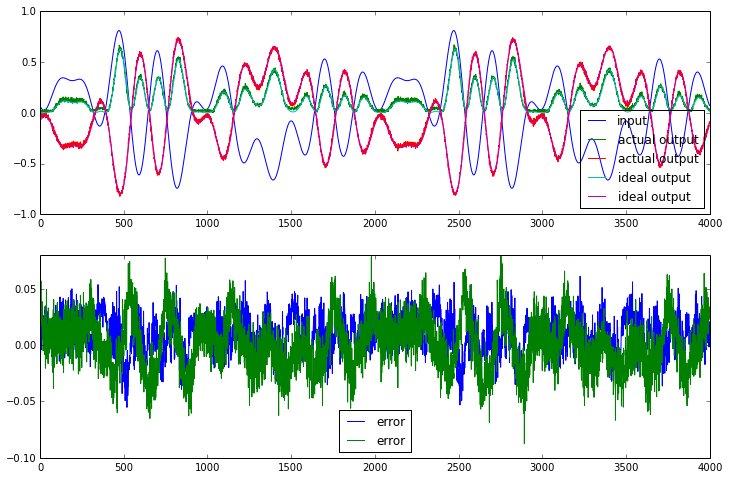

In [7]:
pylab.figure(figsize=(12,8))
pylab.subplot(2, 1, 1)
pylab.plot(test_t, test_signal, label='input')
pylab.plot(test_t, output, label='actual output')
pylab.plot(test_t, filter.filt(test_target, dt=1), label='ideal output', lw=1)
pylab.legend(loc='best')
pylab.subplot(2, 1, 2)
pylab.plot(test_t, error, label='error')
pylab.legend(loc='best')
pylab.show()
